<a href="https://colab.research.google.com/github/prevencao/trading/blob/master/PredictingStockPricesUsingAnLSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f

#**Previsão de série temporal:**

###prevendo preços de ações usando um modelo LSTM

carregando os dados

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [47]:
#lendo o arquivo csv
df = pd.read_csv('TSLA.csv')
print('Número de Linhas e colunas: ', df.shape)
df.head(5)

Número de Linhas e colunas:  (1259, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,262.220001,263.000000,257.820007,259.149994,259.149994,2610900
1,2015-07-13,262.250000,262.549988,256.049988,262.160004,262.160004,2960300
2,2015-07-14,262.100006,265.989990,260.510010,265.649994,265.649994,1907600
3,2015-07-15,266.739990,267.489990,262.079987,263.140015,263.140015,2021600
4,2015-07-16,264.220001,267.200012,263.160004,266.679993,266.679993,1616000


A próxima etapa é dividir os dados em conjuntos de treinamento e teste para evitar overfitting 

e poder investigar a capacidade de generalização de nosso modelo. Para saber mais sobre overfitting, 

[leia este artigo](https://towardsdatascience.com/is-your-model-overfitting-or-maybe-underfitting-an-example-using-a-neural-network-in-python-4faf155398d2)

---
## O valor alvo a ser previsto será o valor do preço da ação “Fechar”.

---


In [48]:
 training_set = df.iloc[:800, 1:2].values
 test_set = df.iloc[800:, 1:2].values
 

É uma boa ideia normalizar os dados antes do ajuste do modelo. 

Isso aumentará o desempenho. Você pode ler mais [aqui](https://towardsdatascience.com/everything-you-need-to-know-about-min-max-normalization-in-python-b79592732b79) para o Min-Max Scaler

Vamos construir os recursos de entrada com intervalo de tempo de 1 dia (intervalo 1):



In [49]:
#Dimensionamento de Recursos (Feature Scaling)
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

#Criação de uma estrutura de dados com 60 etapas de tempo e 1 saída
X_train = []
y_train = []
for i in range(60, 800):
  X_train.append(training_set_scaled[i-60: i, 0])
  y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], 
                               X_train.shape[1], 1))

Agora remodelamos os dados para o seguinte formato (# valores, # etapas de tempo, 

1 saída dimensional).

Agora é hora de construir o modelo. Vamos construir o LSTM com 50 neurônios e 4 camadas 

ocultas. Por fim, atribuiremos 1 neurônio na camada de saída para prever o preço normalizado das ações. 

Usaremos a função de perda MSE e o otimizador de descida gradiente estocástico de 
Adam

In [ ]:
model = Sequential()
#Adicionando a primeira camada LSTM e alguma regularização de Dropout
model.add(LSTM(units = 50, return_sequences = True, 
               input_shape = (X_train.shape[1], 1)))

# Adicionando a segunda camada LSTM e alguma regularização de Dropout
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))

# Adicionando a terceira camada LSTM e alguma regularização de Dropout
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))

# Adicionando a quarta camada LSTM e alguma regularização de Dropout
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adicionando a camada de saída
model.add(Dense(units = 1))

# Compilando o RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Ajustando o RNN ao conjunto de treinamento
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
24/24 [==============================] - 3s 104ms/step - loss: 0.0668
Epoch 2/100
24/24 [==============================] - 3s 115ms/step - loss: 0.0179
Epoch 3/100
24/24 [==============================] - 3s 112ms/step - loss: 0.0126
Epoch 4/100
24/24 [==============================] - 3s 115ms/step - loss: 0.0117
Epoch 5/100
24/24 [==============================] - 3s 115ms/step - loss: 0.0135
Epoch 6/100
24/24 [==============================] - 3s 116ms/step - loss: 0.0126
Epoch 7/100
24/24 [==============================] - 3s 121ms/step - loss: 0.0115
Epoch 8/100
24/24 [==============================] - 3s 119ms/step - loss: 0.0110
Epoch 9/100
24/24 [==============================] - 3s 113ms/step - loss: 0.0109
Epoch 10/100
24/24 [==============================] - 3s 112ms/step - loss: 0.0096
Epoch 11/100
24/24 [==============================] - 3s 115ms/step - loss: 0.0100
Epoch 12/100
24/24 [==============================] - 3s 120ms/step - loss: 0.0093
Epoch 13/100


Prepare os dados de teste (reformule-os)

In [ ]:
#Obtendo o preço de ação previsto para 2017
dataset_train = df.iloc[:800, 1:2]
dataset_test = df.iloc[800:, 1:2]
dataset_total = pd.concat((dataset_train, 
                           dataset_test), axis = 0)

inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []

for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_test.shape)

(459, 60, 1)


Faça previsões usando o conjunto de teste

In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

visualisando os dados

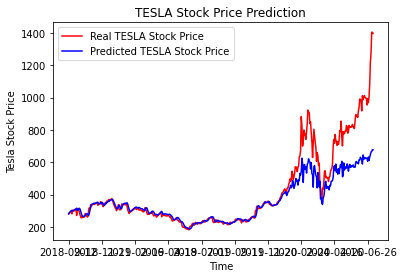

In [34]:
plt.plot(df.loc[800:, 'Date'], dataset_test.values,
         color= 'red', label='Real TESLA Stock Price')
plt.plot(df.loc[800:, 'Date'], predicted_stock_price, 
         color='blue', label='Predicted TESLA Stock Price')

plt.xticks(np.arange(0, 459, 50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()